In [9]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [10]:
if IN_COLAB:
    # Install pylibCZIrw and dependencies
    ! pip install --upgrade pip
    ! pip install pylibCZIrw cztile matplotlib tqdm scikit-image pooch requests

# pylibCZIrw - Tutorial

In this notebook one can see how to read and write CZI (Carl Zeiss Image) files using from Python using [pylibCZIrw](https://pypi.org/project/pylibczirw/). This package is wrapper for the [libCZI (C++) library](https://github.com/ZEISS/libczi) and can be used both in Windows and Linux.

## Remarks

* At the moment, [pylibCZIrw](https://pypi.org/project/pylibczirw/) completely abstracts away the subblock concept, both in the reading and in the writing APIs.
* If [pylibCZIrw](https://pypi.org/project/pylibczirw/) is extended in the future to support subblock-based access (e.g. accessing acquisition tiles), this API must not be altered.

## Disclaimer

This content of this repository is free to use for everybody. Carl Zeiss Microscopy GmbH's ZEN software undertakes no warranty concerning the use of those scripts, image analysis settings and ZEN experiments. Use them on your own risk.

**By using any of those examples you agree to this disclaimer.**

## Required Module Imports

Both reading and writing APIs are contained within the **czi** object in pylibCZIrw, so let's start by importing it.

Additional modules are imported alongside the **pylibCZIrw** package.

In [11]:
from pylibCZIrw import czi as pyczi
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from lxml import etree

# show the used python env
print("Using:", sys.executable)

Using: f:\Documents\miniconda3\envs\zen_python\python.exe


## Define parameters for data loading

In [12]:
# Folder containing the input data
INPUT_FOLDER = './data/'

# Path to the data on GitHub
GITHUB_DATA_PATH = 'https://raw.githubusercontent.com/zeissmicroscopy/ZEN_Python_OAD_workshop/main/workshop/notebooks/data.zip'

## Download data if it's not available on disk
If this notebook is run e.g. as a colab notebook, it does not have access to the data folder on GitHub via disk access. In that case we need to download the data from GitHub first.

In [13]:
import requests

# Download training data
if not (os.path.isdir(INPUT_FOLDER)):
    compressed_data = './data.zip'
    if not os.path.isfile(compressed_data):
        import io

        response = requests.get(GITHUB_DATA_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)

    import zipfile

    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')

## Opening a CZI (read-only)

A CZI file can be opened in a context manager.

`with czi.open_czi(file_path) as czi:`

**This will open the CZI in read-only mode.**

### Open a CZI and read metadata

We can open a czi using a context manager and then read the full metadata either as a raw XML string or as a dictionary

In [14]:
# define the filenames for the CZI images to be read
czifile_scenes = os.path.join(INPUT_FOLDER, r"w96_A1+A2.czi")
czifile_5dstack = os.path.join(INPUT_FOLDER, r"T=3_Z=5_CH=2_X=240_Y=170.czi")

# open the CZI for reading using a context manager (preferred way to do it)
with pyczi.open_czi(czifile_5dstack) as czidoc:
    # get the raw metadata as XML
    md_xmlstring = czidoc.raw_metadata
    md_xmlroot = etree.fromstring(md_xmlstring)

# just show some parts of the XML string
print(md_xmlstring[:510])

<?xml version="1.0"?>
<ImageDocument>
 <Metadata>
  <Experiment Version="1.1">
   <RunMode>OptimizeBeforePerformEnabled,ValidateAndAdaptBeforePerformEnabled</RunMode>
   <BeforeHardwareSetting>Before Exp [AF635, AF555, AF594, AF514, AF405, PGC] Smart</BeforeHardwareSetting>
   <AfterHardwareSetting>After Exp [AF635, AF555, AF594, AF514, AF405, PGC] Smart</AfterHardwareSetting>
   <ExperimentBlockIndex>0</ExperimentBlockIndex>
   <IsSegmented>false</IsSegmented>
   <IsStandardMode>true</IsStandardMode>
   


In [15]:
# open the CZI for reading
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get the raw metadata as a dictionary
    md_dict = czidoc.metadata

# show the keys of the metadata dictionary
for key, values in md_dict["ImageDocument"]["Metadata"].items():
    print(key)

Experiment
HardwareSetting
CustomAttributes
Information
Scaling
DisplaySetting
Layers
Appliances


In [16]:
# show some parts of the metadata dictionary
print(json.dumps(md_dict["ImageDocument"]["Metadata"]["Information"]["Image"], sort_keys=False, indent=4))

{
    "SizeX": "21718",
    "SizeY": "1440",
    "SizeS": "2",
    "SizeB": "1",
    "SizeM": "1",
    "OriginalCompressionMethod": "Uncompressed",
    "OriginalEncodingQuality": "100",
    "AcquisitionDateAndTime": "2016-07-04T14:52:08.4473414Z",
    "SizeC": "2",
    "ComponentBitCount": "14",
    "PixelType": "Gray16",
    "Dimensions": {
        "Channels": {
            "Channel": [
                {
                    "@Id": "Channel:0",
                    "@Name": "AF568",
                    "ExcitationWavelength": "577",
                    "EmissionWavelength": "603",
                    "DyeId": "McNamara-Boswell-0049",
                    "DyeDatabaseId": "66071726-cbd4-4c41-b371-0a6eee4ae9c5",
                    "Color": "#FFFF1800",
                    "Fluor": "Alexa Fluor 568",
                    "ExposureTime": "150000000",
                    "IlluminationType": "Epifluorescence",
                    "ContrastMethod": "Fluorescence",
                    "PixelType

## Get Image dimensions
There are different properties that allow us to retrieve information about dimensions.
The **`total_bounding_box`** gives us all the dimensions of all **orthogonal planes** of the CZI image file.

In [17]:
with pyczi.open_czi(czifile_5dstack) as czidoc:
    
    # get the image dimensions as an dictionary, where the key identifies the dimension
    total_bounding_box = czidoc.total_bounding_box

print(total_bounding_box)

{'T': (0, 3), 'Z': (0, 5), 'C': (0, 2), 'B': (0, 1), 'X': (0, 240), 'Y': (0, 170)}


The **`total_bounding_rectangle`** gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the **`total_bounding_box`**.

In [18]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get the total bounding box for all scenes
    total_bounding_rectangle = czidoc.total_bounding_rectangle

print(total_bounding_rectangle)

Rectangle(x=0, y=0, w=21718, h=1440)


**Scenes are not orthogonal to the other dimensions.**
They are contained within the 2D planes and can be seen simply as tags for certain regions.

The **`scene_bounding_rectangle`** give us the bounding rectangle for each scene.

In [19]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get the bounding boxes for each individual scene
    scenes_bounding_rectangle = czidoc.scenes_bounding_rectangle

print(scenes_bounding_rectangle)

{0: Rectangle(x=0, y=0, w=1960, h=1416), 1: Rectangle(x=19758, y=24, w=1960, h=1416)}


## Get the pixel type
A channel's pixel type can be discovered with using: **`get_channel_pixel_type`**

In [20]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get the pixel type for the 1st channel
    c0_pixel_type = czidoc.get_channel_pixel_type(0)

print(c0_pixel_type)

Gray16


Or we can simply get all pixel types using: **`pixel_types`**

In [21]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get all pixel types as a dictionary, where the key is the channel index
    pixel_type = czidoc.pixel_types

print(pixel_type)

{0: 'Gray16', 1: 'Gray16'}


## Read pixel data
Pixel data is read and returned as a numpy arry. The shape of the returned array and its data type will depend on the specified `pixel_type`.
- BGR pixel type -> [y, x, 3]
- Gray pixel type -> [y, x, 1]

The background_pixel determines the pixel value for the background (i.e. regions where no pixel data exists),
 and must be consistent with the `pixel_type`

|pixel_type | background_pixel type | Default value  | 
--- | --- | ---
|BGR|3-value tuple |(0, 0, 0)|
|Gray|Scalar value bounded by the gray scale|0|

### Read whole 2D plane

In order to **`read`** pixel data from a CZI image file it is important to understand the concept of "planewise reading".

Reading data planewise means that every read operation yields a 2D array with the shape (Y, X, 1) or (Y, X, 3) depending on the requested pixel type.
We can specify which 2D plane to read using the **`plane`** argument (dictionary).

* **`plane = {'C': 0, 'Z': 2, 'T': 1}`** - this will read a 2D plane from C=0, Z=2 and T=1
* if **`plane`** is not specified at all the default is to use the 1st index for all dimensions

In order to read a complete Z-Stack, one would have to read each of the Z-slices using the plane argument. This can be easily created by "wrapping" those calls into some utility functions.
To get started let's read a complete 2D plane.

Array Shape:  (170, 240, 1)


Text(0.5, 1.0, 'Frame_2')

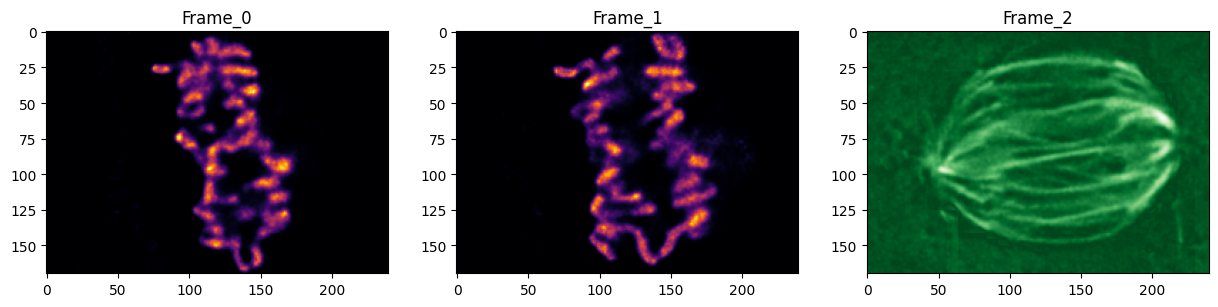

In [22]:
with pyczi.open_czi(czifile_5dstack) as czidoc:
    
    # define some plane coordinates
    plane_1 = {'C': 0, 'Z': 2, 'T': 1}
    plane_2 = {'C': 1, 'Z': 3, 'T': 2}

    # equivalent to reading {'C': 0, 'Z': 0, 'T': 0}
    frame_0 = czidoc.read()

    # get the shape of the 2d plane - the last dime indicates the pixel type
    # 3 = BGR and 1 = Gray
    print("Array Shape: ", frame_0.shape)

    # get specific planes 
    frame_1 = czidoc.read(plane=plane_1)
    frame_2 = czidoc.read(plane=plane_2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(frame_0[..., 0], cmap=cm.inferno)
ax[0].set_title("Frame_0")
ax[1].imshow(frame_1[..., 0], cmap=cm.inferno)
ax[1].set_title("Frame_1")
ax[2].imshow(frame_2[..., 0], cmap=cm.Greens_r)
ax[2].set_title("Frame_2")

### Read ROI inside a specific 2D plane

We can also read an ROI within the 2D plane by using the **`roi`** argument.
This is particularly useful when dealing with large images whose planes would not fit into memory.

The **`roi`** is a tuple defined as a (axis-aligned) rectangle in **(x, y, w, h)** form, with:

* x = x coordinate of upper-left point
* y = y coordinate of upper-left point
* w = rectangle width
* h = rectangle height

Text(0.5, 1.0, 'ch1')

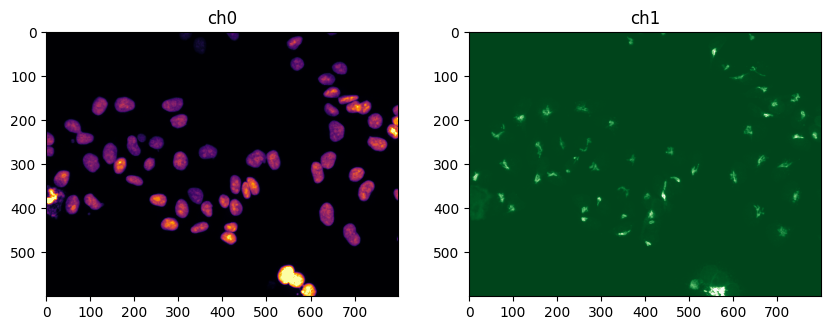

In [23]:
# define the ROI using upper left, width and height as coordinates
my_roi = (200, 400, 800, 600)

with pyczi.open_czi(czifile_scenes) as czidoc:
    
    ch0 = czidoc.read(roi=my_roi, plane={'C': 0})
    ch1 = czidoc.read(roi=my_roi, plane={'C': 1})

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ch0[..., 0], cmap=cm.inferno, vmin=100, vmax=4000)
ax[0].set_title("ch0")
ax[1].imshow(ch1[..., 0], cmap=cm.Greens_r, vmin=100, vmax=4000)
ax[1].set_title("ch1")

### Read ROI only for one scene
We can also get pixel data exclusively from one scene using the **`scene`** argument. This argument acts as
a filter returning only data from the specified scene. If not set, data from all scenes is returned.

Text(0.5, 1.0, 'scene:1 ch:0')

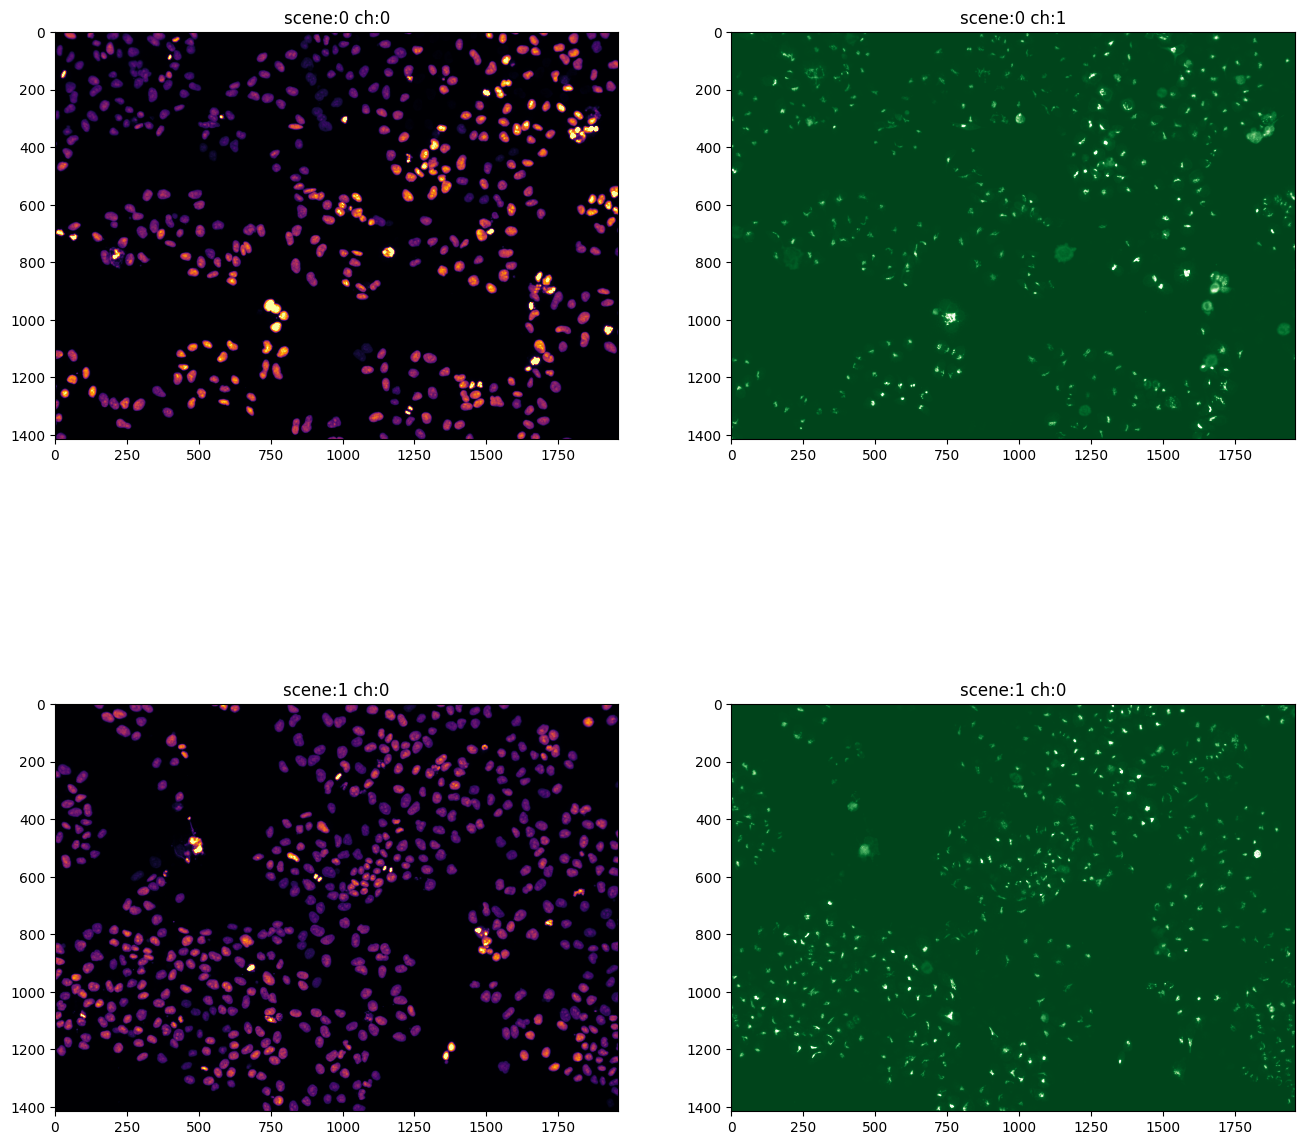

In [24]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # read a 2D image from a specific channel and scene
    c0_s0 = czidoc.read(plane={'C': 0}, scene=0)
    c1_s0 = czidoc.read(plane={'C': 1}, scene=0)
    c0_s1 = czidoc.read(plane={'C': 0}, scene=1)
    c1_s1 = czidoc.read(plane={'C': 1}, scene=1)

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0, 0].imshow(c0_s0[..., 0], cmap=cm.inferno, vmin=100, vmax=4000)
ax[0, 0].set_title("scene:0 ch:0")
ax[0, 1].imshow(c1_s0[..., 0], cmap=cm.Greens_r, vmin=100, vmax=4000)
ax[0, 1].set_title("scene:0 ch:1")
ax[1, 0].imshow(c0_s1[..., 0], cmap=cm.inferno, vmin=100, vmax=4000)
ax[1, 0].set_title("scene:1 ch:0")
ax[1, 1].imshow(c1_s1[..., 0], cmap=cm.Greens_r, vmin=100, vmax=4000)
ax[1, 1].set_title("scene:1 ch:0")

### Additional parameters

We can specify the **`pixel_type`** in which we want the data to be read. If the desired pixel type is not specified, the data is returned in its original pixel format.

In [25]:
with pyczi.open_czi(czifile_5dstack) as czidoc:
    
    # get image pixel and specify the desired pixel type
    frame_gray8 = czidoc.read(pixel_type='Gray8')
    frame_gray32float = czidoc.read(pixel_type='Gray32Float')
    frame_bgr48 = czidoc.read(pixel_type='Bgr48')

print('shape {0}, data type {1}'.format(frame_gray8.shape, frame_gray8.dtype))
print('shape {0}, data type {1}'.format(frame_gray32float.shape, frame_gray32float.dtype))
print('shape {0}, data type {1}'.format(frame_bgr48.shape, frame_bgr48.dtype))

shape (170, 240, 1), data type uint8
shape (170, 240, 1), data type float32
shape (170, 240, 3), data type uint16


We can also specify a **`zoom`** factor between 0 and 1. This can be very useful to read images at a lower resolution,
because not every application requires the full resolution.

Shape Zoomlevel =  1.0 (300, 300, 1)
Shape Zoomlevel =  0.25 (75, 75, 1)


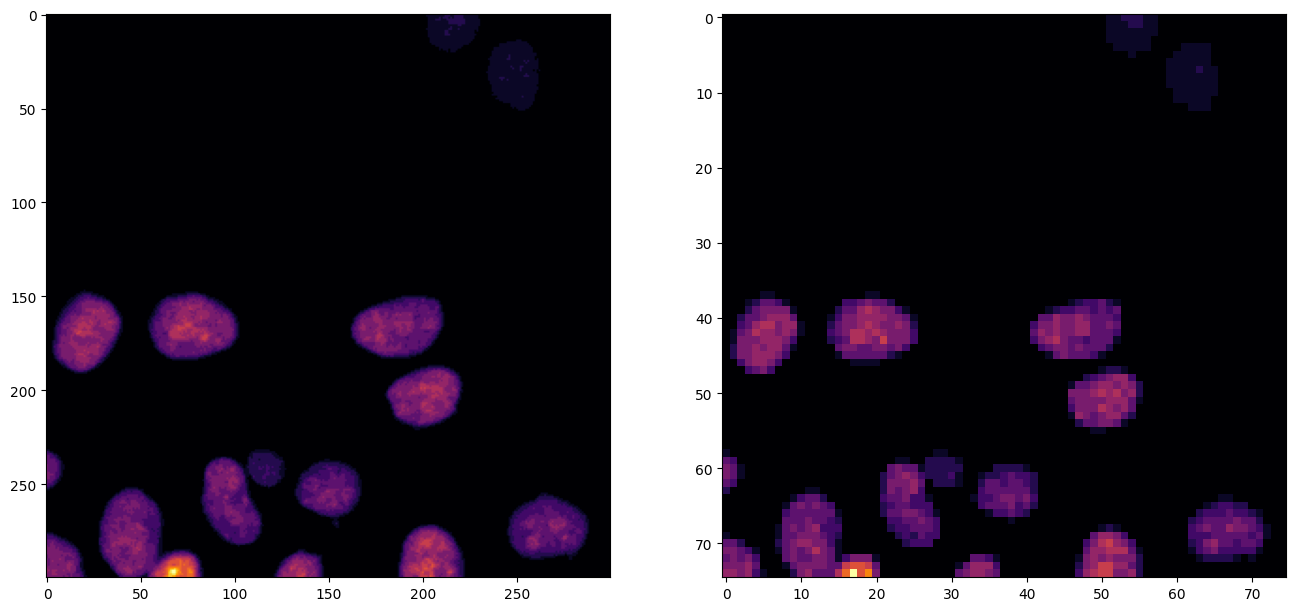

In [26]:
# define the ROI using upper left, width and height as coordinates
my_roi = (300, 400, 300, 300)

# define two different zoom factors
zl1 = 1.0
zl2 = 0.25

with pyczi.open_czi(czifile_scenes) as czidoc:
    
    z1 = czidoc.read(plane={'C': 0}, roi=my_roi, scene=0, zoom=zl1, pixel_type='Gray8')
    z2 = czidoc.read(plane={'C': 0}, roi=my_roi, scene=0, zoom=zl2, pixel_type='Gray8')

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(z1[..., 0], cmap=cm.inferno)
ax[1].imshow(z2[..., 0], cmap=cm.inferno)

print("Shape Zoomlevel = ", zl1, z1.shape)
print("Shape Zoomlevel = ", zl2, z2.shape)

## Writing a CZI file

* **The writing API only allows creating new CZI files.**
* editing existing czi file is not supported.
* writing API is follows the same principles as the reading API.

### Create a new CZI

Similarly to reading, before writing, we must create a CZI instance.
Ideally this is done using a context manager again.

### Write pixel data

Writing pixel data is very similar to reading albeit with fewer arguments:

* the **`plane`** to which the pixel data should be written.
* the data to be written, as a numpy array.

The pixel type in which the data is written is automatically determined from the shape and data type of the provided array.

In [27]:
# let's use sample exmaple data from scikit-image
from skimage import data

data = data.kidney()

print(f'number of dimensions: {data.ndim}')
print(f'shape: {data.shape}')
print(f'dtype: {data.dtype}')

number of dimensions: 4
shape: (16, 512, 512, 3)
dtype: uint16


In order to create a new CZI file we must provide the file name.
The optional flag (**`exist_ok`**) allows overwriting if set to **`True`** (default is **`False`**).

In [28]:
# create the filename for the new CZI image file
newczi_4dstack = os.path.join(os.getcwd(), "newCZI_z=16_ch=3.czi")
numCH = 3
numZ = 16

# open a new CZI and allow overwrite (!!!) to play around ...
with pyczi.create_czi(newczi_4dstack, exist_ok=True) as czidoc_w:

    # loop over all z-planes and channels
    for z, ch in it.product(range(numZ), range(numCH)):

        # get the 2d array for the current plane and add axis to get (Y, X, 1) as shape
        array2d = data[z, ..., ch][..., np.newaxis]

        # write the plane with shape (Y, X, 1) to the new CZI file
        czidoc_w.write(
            data=array2d,
            plane={"Z": z, "C": ch}
        )

  0%|          | 0/48 [00:00<?, ?it/s]

<p><img src="screenshots/new_czi_z16_c3.png" title="newCZI_z=16_ch=3.czi - shown in ZEN blue" width="1000"></p>

We can also write data to a specific **`location`** within the plane by providing the upper left pixel coordinates.

To illustrate this idea let's write all z-planes from the image "side-by-side" into a new CZI image.

In [29]:
# create the filename for the new CZI image file
newczi_zloc = os.path.join(os.getcwd(), "newCZI_zloc.czi")
xstart = 0
ch = 0

with pyczi.create_czi(newczi_zloc, exist_ok=True) as czidoc_w:

    # loop over all z-planes
    for z in tqdm(range(numZ)):

        # get the 2d array for the current plane and add axis to get (Y, X, 1) as shape
        array2d = data[z, ..., ch][..., np.newaxis]

        # for fun - write the z-planes to different locations
        czidoc_w.write(
            data=array2d,
            plane={"C": ch},
            location=(xstart, 0)
        )

        # change the x-position for the next round to write "side-by-side"
        xstart = xstart + 512

100%|██████████| 16/16 [00:00<00:00, 787.30it/s]


<p><img src="screenshots/new_czi_locations.png" title="new_czi_locations.czi - shown in ZEN blue" width="1000"></p>

### Write scenes

Writing a scene is in fact "just" writing pixel data to a specific region within a plane and tagging it with a **`scene`** index.
To illustrate this we now will write the z-planes to different scenes at different locations.

In [30]:
# first step is to create some kind of grid of locations
locx = []
locy = []
xystart = 0
offset = 700

# create the list for the 4x4 grid locations for the 16 planes 
for x, y in it.product(range(4), range(4)):
    
    locx.append(xystart + offset * x)
    locy.append(xystart + offset * y)

  0%|          | 0/16 [00:00<?, ?it/s]

In [31]:
# create the filename for the new CZI image file
newczi_zscenes = os.path.join(os.getcwd(), "newCZI_scenes.czi")
ch = 1

with pyczi.create_czi(newczi_zscenes, exist_ok=True) as czidoc_w:

    # loop over all z-planes
    for z in tqdm(range(numZ)):

        # get the 2d array for the current plane and add axis to get (Y, X, 1) as shape
        array2d = data[z, ..., ch][..., np.newaxis]

        # for "fun" - write the z-planes to different locations using the locations we just created
        czidoc_w.write(
            data=array2d,
            plane={"C": ch},
            scene=z,
            location=(locx[z], locy[z])
        )

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 693.67it/s]


<p><img src="screenshots/new_czi_scenes.png" title="new_czi_scenes - shown in ZEN blue" width="900"></p>

### ZSTD Compression

#### Why we have used ZSTD Compression?
It is a fast compression technique, which provides the high compression ratios. We are handling these three modes:

1. uncompressed: - Default setting, the image would not be compressed.
2. zstd0 - You can specify the parameters of it like "explicitlevel" between -131072 and 22. <b>(e.g. "zstd0:ExplicitLevel=10")</b>
3. zstd1 - You can specify the parameters of it like "explicitlevel" between -131072 and 22 or "preprocess" - only have HiLoByteUnpack. This is only done for zstd1 and for pixel types gray16 and Bgr48. <b>(e.g. "zstd1:ExplicitLevel=10" or "zstd1:Preprocess=HiLoByteUnpack")</b>

To read more: https://facebook.github.io/zstd/

In [32]:
# define the compression parameters

#cmp = "zstd0:ExplicitLevel=3"
#cmp = "zstd1:ExplicitLevel=10"
#cmp = "zstd1:Preprocess=HiLoByteUnpack;ExplicitLevel=3"
cmp = "zstd1:Preprocess=HiLoByteUnpack;Level=Best"
#cmp = "zstd1:Preprocess=HiLoByteUnpack;ExplicitLevel=1"

# getting the 2-d array from the kidney data.
array2d = data[0,...,1]

In [33]:
# create the filename for the new CZI image file
newczi_compressed = os.path.join(os.getcwd(), "newCZI_compressed.czi")
newczi_uncompressed = os.path.join(os.getcwd(), "newCZI_uncompressed.czi")

# write a CZI file using ZSTD compression
with pyczi.create_czi(newczi_compressed, exist_ok=True, compression_options = cmp) as czidoc_w:

    czidoc_w.write(
        data=array2d,
        plane={"C": 0, "T": 0, "Z": 0},
        scene=0,
        location=(0,0)
    )

# write a CZI file without using compression
with pyczi.create_czi(newczi_uncompressed, exist_ok=True, compression_options = "uncompressed:") as czidoc_w:

    czidoc_w.write(
        data=array2d,
        plane={"C": 0, "T": 0, "Z": 0},
        scene=0,
        location=(0,0)
    )

In [34]:
size_comp = os.path.getsize("newCZI_compressed.czi")/1024.0
print(f"Size compressed   : {size_comp} KB ")

size = os.path.getsize("newCZI_uncompressed.czi")/1024.0
print(f"Size uncompressed : {size} KB")

print(f"Compression Ratio : {np.round(size/size_comp, 2)}")

Size compressed   : 250.625 KB 
Size uncompressed : 514.21875 KB
Compression Ratio : 2.05


### Write Metadata

**Metadata is automatically written**, however, we can write some additional metadata by explicitly calling
 **`write_metadata`** with the following **optional** parameters:

- **`document_name`** (in ZEN: "Title")
- **`channel_names`** (in ZEN: "Channel Names")
- **`custom_attributes`** (Not visible in ZEN)
- **`display_settings`**
- **`scale_x`**, **`scale_y`**, **`scale_z`** in **meters (!)** (in ZEN: "Scaling (per Pixel)")

The parameter **`custom_attributes`** allows customized attributes with type int, float, boolean or string. If an attribute already exists, writing the same attribute again will replace the existing value.

The parameter **`display_settings`** allows to write metadata specific for the presentation of channels in the viewing software.

This list of parameters will be extended on a case-by-case basis in the future.

***

In [35]:
# create the filename for the new CZI image file
newczi_mdata = os.path.join(os.getcwd(), "newczi_mdata.czi")
numZ = 16
ch = 0

# open a new CZI and allow overwrite (!!!) to play around ...
with pyczi.create_czi(newczi_mdata, exist_ok=True) as czidoc_w:

    # loop over all z-planes
    for z in tqdm(range(numZ)):

        # get the 2d array for the current plane
        array2d = data[z, ..., ch]

        # write the 2D plane to the new CZI file
        czidoc_w.write(
            data=array2d,
            plane={"Z": z}
        )

    # write the document title, channel names, custom attributes and XYZ scaling to the CZI file
    czidoc_w.write_metadata(
        document_name='new_czi_z=16',
        channel_names={0: "Red"},
        custom_attributes={"key1": "value1", "key2": "value2"},
        display_settings = {
            0: pyczi.ChannelDisplaySettingsDataClass(
                True, pyczi.TintingMode.Color,
                pyczi.Rgb8Color(np.uint8(255), np.uint8(0), np.uint8(0)),
                0.2,
                0.8
            )
        },
        scale_x=0.1 * 10 ** -6,
        scale_y=0.1 * 10 ** -6,
        scale_z=0.3 * 10 ** -6
    )

100%|██████████| 16/16 [00:00<00:00, 614.54it/s]


<p><img src="screenshots/new_czi_z16_metadata.png" title="new_czi_z=16_metadata - shown in ZEN blue" width="900"></p>

## Tiling a large image

The read and write API allow the user to work with large images by allowing breaking down the access using the **`roi`** argument.
However, defining these rois (aka tiles) can be a cumbersome process.

The **[cztile](https://pypi.org/project/cztile/)** package was created to answer this need.

**The package contains pure logic for tiling a rectangle. This means it is not file or format bound in any way.**

Let's read the original file using cztile and write a new with the same dimensions and scenes but with
random data instead.

### Define a 2d processing function

The benefits of tiling are evident when the data needs to be broken down for processing.
Segmentation using Deep Neural Networks is a great example of a task where images must be cut to fit.
We can use **czitile** to break down the image into tiles with some overlap.

We can illustrate this with a simpler 2D processing function first.

In [36]:
from skimage.filters import gaussian


# define a generic 2D processing function - could by a DL segmentation as well :-)
def process2d(image2d: np.ndarray, **kwargs: int) -> np.ndarray:

    # insert or modify the desired processing function here
    image2d = gaussian(
        image2d, sigma=kwargs["sigma"],
        preserve_range=True,
        mode='nearest'
    ).astype(image2d.dtype)

    return image2d

In [37]:
# import the "tiling strategy" from the cztile package
from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D

# create the filename for the new CZI image file
newczi_tile = os.path.join(os.getcwd(), "newczi_tilewise.czi")

# specify the original CZI file to be read
czifile_orig = os.path.join(INPUT_FOLDER, r"DAPI_PGC.czi")

# create a "tile" by specifying the desired tile dimension and the

# minimum required overlap between tiles (depends on the processing)
tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(
    total_tile_width=1600,
    total_tile_height=1400,
    min_border_width=128
)

# create CZI instance to read some metadata
with pyczi.open_czi(czifile_orig) as czidoc_r:

    # get the size of the bounding rectange for the scence
    tiles = tiler.tile_rectangle(czidoc_r.scenes_bounding_rectangle[0])
    numtiles = len(tiles)

# show the created tile locations
for tile in tiles:
    print(tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h)

0 0 1600 1400
0 808 1600 1400
1152 0 1600 1400
1152 808 1600 1400


### Opening a CZI file for reading and write to a new CZI in parallel

The idea of tile-wise processing can enable the following approach:

* open the "original CZI image file for reading
* tile the image using **[czitile](https://pypi.org/project/cztile/)**
* use the computed tiles as the **roi** parameters to read a "tile" of data
* apply the desired processing to the read tile
* write the processed tile into the new CZI at the correct location using the tile properties

100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


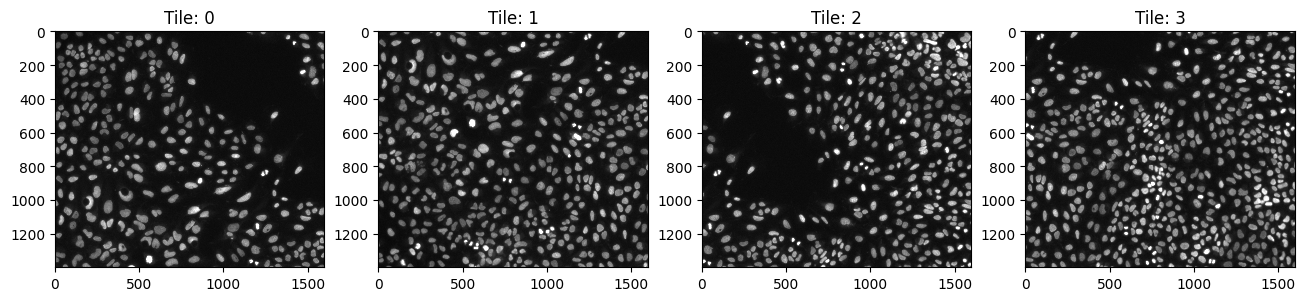

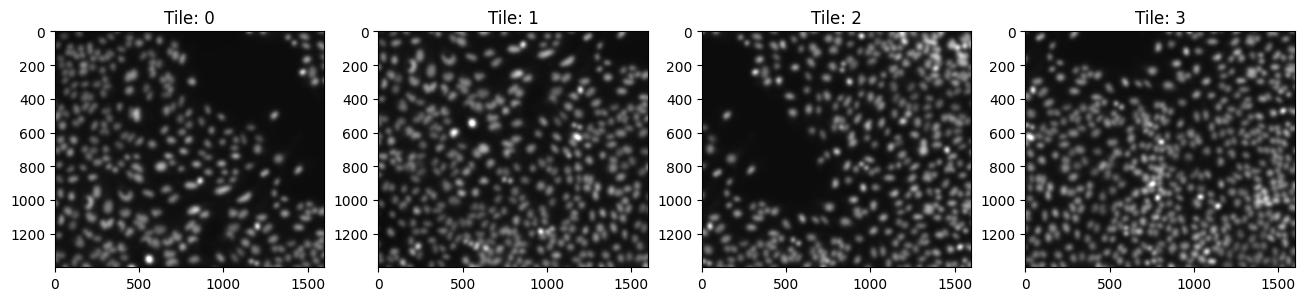

In [38]:
# open an existing CZI file for reading planes and a new CZI to insert
# the newly processed chunks into the new CZI file

# create to figures
fig1, ax1 = plt.subplots(1, 4, figsize=(16, 8))
fig2, ax2 = plt.subplots(1, 4, figsize=(16, 8))

# counter figures
a = 0

# open a CZI instance to read and in parallel one to write
with pyczi.open_czi(czifile_orig) as czidoc_r:

    with pyczi.create_czi(newczi_tile, exist_ok=True) as czidoc_w:

        # loop over all tiles created by the "tiler"
        for tile in tqdm(tiles):

            # read a specific tile from the CZI using the roi parameter
            tile2d = czidoc_r.read(
                plane={"C": 0},
                roi=(
                    tile.roi.x,
                    tile.roi.y,
                    tile.roi.w,
                    tile.roi.h
                )
            )

            # process the current tile using a function
            tile2d_processed = process2d(tile2d, sigma=11)

            # show the tiles to illustrate the idea
            ax1[a].imshow(tile2d[..., 0], interpolation="nearest", cmap="gray", vmin=100, vmax=4000)
            ax1[a].set_title("Tile: " + str(a))
            ax2[a].imshow(tile2d_processed[..., 0], interpolation="nearest", cmap="gray", vmin=100, vmax=4000)
            ax2[a].set_title("Tile: " + str(a))

            # write the new CZI file using the processed data
            czidoc_w.write(
                tile2d_processed,
                plane={"C": 0},
                location=(
                    tile.roi.x,
                    tile.roi.y
                )
            )

            a += 1

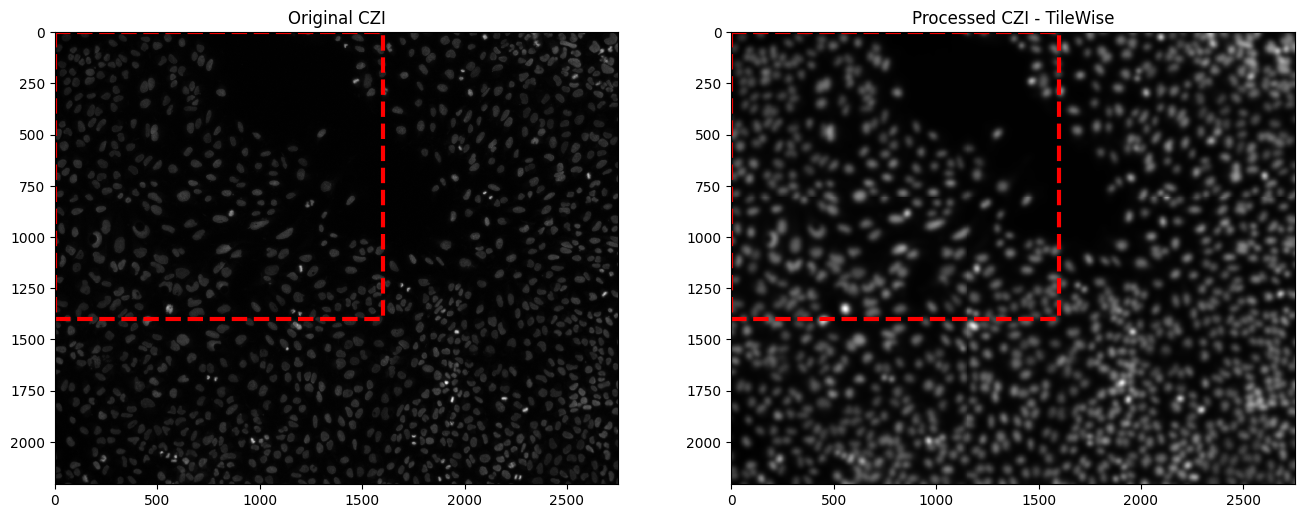

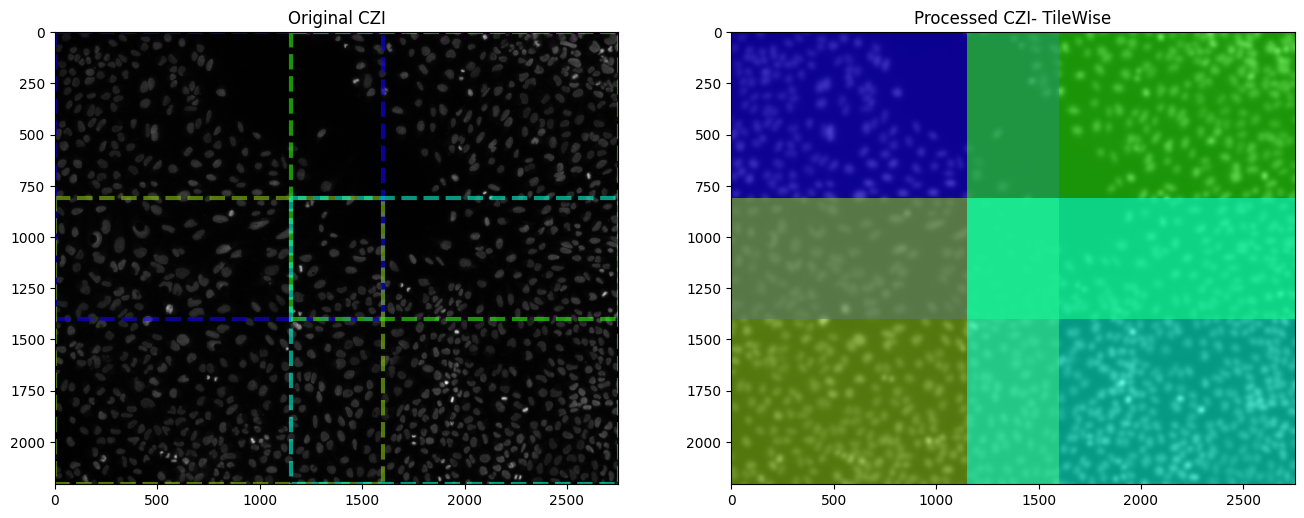

In [39]:
import random

# read the CZI pixel data
with pyczi.open_czi(czifile_orig) as czidoc_r:
    data_orig = czidoc_r.read(plane={"C": 0})

with pyczi.open_czi(newczi_tile) as czidoc_r:
    data_processed = czidoc_r.read(plane={"C": 0})

# show the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(data_orig[..., 0], interpolation="nearest", cmap="gray")
ax1.set_title('Original CZI')
ax2.imshow(data_processed[..., 0], interpolation="nearest", cmap="gray")
ax2.set_title('Processed CZI - TileWise')

# define the tile to be shown
tn = 0

# add rectangle to plot to visualize the tile
ax1.add_patch(
    Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=3,
              ls="--")
)

ax2.add_patch(
    Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=3,
              ls="--")
)

# show the results
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8))
ax3.imshow(data_orig[..., 0], interpolation="nearest", cmap="gray")
ax3.set_title('Original CZI')
ax4.imshow(data_processed[..., 0], interpolation="nearest", cmap="gray")
ax4.set_title('Processed CZI- TileWise')

edge_color_opacity = 1.0
face_color_opacity = 0.6

# visualize a single tile
for tile in tiles:
    # use random colors to visualize the tiles
    r = random.random()
    b = random.random()
    g = random.random()
    edgecolor = (r, g, b, face_color_opacity)
    facecolor = (r, g, b, face_color_opacity)

    # add rectangle to plot
    ax3.add_patch(
        Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=edgecolor,
                  fill=False,
                  lw=3,
                  ls="--")
    )

    ax4.add_patch(
        Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  facecolor=facecolor,
                  fill=True,
                  lw=3,
                  ls="--")
    )

    c = + 1